<a href="https://colab.research.google.com/github/Heoyuna0819/machine_learning/blob/main/WIDSM_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)
tf.random.set_seed(42)

In [2]:
#1. Load & Clean
names = ["user_id", "activity", "timestamp", "x_axis", "y_axis", "z_axis", "NaN"]
df = pd.read_csv("/content/drive/MyDrive/WISDM_ar_v1.1_raw.txt",
                 header=None, names=names, comment=';')

df = df.drop(columns=["NaN"])
# 세미콜론/문자 → 숫자
for col in ["x_axis", "y_axis", "z_axis"]:
    df[col] = pd.to_numeric(df[col].astype(str).str.replace(";", "", regex=True), errors="coerce")

# 결측치 제거
df = df.dropna().reset_index(drop=True)

In [3]:
df.head()

,user_id,activity,timestamp,x_axis,y_axis,z_axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


In [4]:
#2. Split by user_id
df_train = df[df["user_id"] <= 20].copy()
df_test  = df[(df["user_id"] > 20) & (df["user_id"] <= 36)].copy()

In [5]:
#3. Scale
scale_cols = ["x_axis", "y_axis", "z_axis"]
scaler = RobustScaler().fit(df_train[scale_cols])
df_train.loc[:, scale_cols] = scaler.transform(df_train[scale_cols])
df_test.loc[:, scale_cols]  = scaler.transform(df_test[scale_cols])


In [6]:
#4. Label Encoding
le = LabelEncoder()
df_train["activity_enc"] = le.fit_transform(df_train["activity"])
df_test["activity_enc"]  = le.transform(df_test["activity"])

In [7]:
#5. Sliding Window
def create_windows(X_df, y_ser, time_steps=200, step=40):
    X, y = [], []
    for i in range(0, len(X_df) - time_steps, step):
        block = X_df.iloc[i:i+time_steps].values
        labels = y_ser.iloc[i:i+time_steps].values
        vals, cnts = np.unique(labels, return_counts=True)
        major = vals[np.argmax(cnts)]
        X.append(block)
        y.append(major)
    return np.asarray(X), np.asarray(y).reshape(-1, 1)

TIME_STEPS, STEP = 200, 40
X_train_all, y_train_all = create_windows(df_train[scale_cols], df_train["activity_enc"],
                                          time_steps=TIME_STEPS, step=STEP)
X_test, y_test = create_windows(df_test[scale_cols], df_test["activity_enc"],
                                time_steps=TIME_STEPS, step=STEP)

In [8]:
#6. Train/Valid Split
y_flat = y_train_all.flatten()
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_all, y_flat, test_size=0.2, random_state=42, stratify=y_flat
)

In [9]:
#7. One-Hot Encoding
enc = OneHotEncoder(sparse_output=False)
y_tr_oh  = enc.fit_transform(y_tr.reshape(-1, 1))
y_val_oh = enc.transform(y_val.reshape(-1, 1))
y_test_oh = enc.transform(y_test.reshape(-1, 1))

n_timesteps, n_features = X_tr.shape[1], X_tr.shape[2]
n_classes = y_tr_oh.shape[1]
print("Input shape:", (n_timesteps, n_features), "Classes:", n_classes, le.classes_)


Input shape: (200, 3) Classes: 6 ['Downstairs' 'Jogging' 'Sitting' 'Standing' 'Upstairs' 'Walking']


In [10]:
#8. CNN Model
inputs = keras.Input(shape=(n_timesteps, n_features))
x = keras.layers.Conv1D(64, 5, strides=2, padding="same", activation="relu")(inputs)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPooling1D(2)(x)

x = keras.layers.Conv1D(96, 3, padding="same", activation="relu")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPooling1D(2)(x)

x = keras.layers.Conv1D(128, 3, padding="same", activation="relu")(x)
x = keras.layers.BatchNormalization()(x)


x = keras.layers.GlobalAveragePooling1D()(x)


x = keras.layers.Dense(128, activation="relu")(x)
x = keras.layers.Dropout(0.3)(x)

outputs = keras.layers.Dense(n_classes, activation="softmax")(x)

model = keras.Model(inputs, outputs)
model.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 200, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 100, 64)        │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 100, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 50, 96)         │        18,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 50, 96)         │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 25, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 25, 128)        │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 25, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,982 (292.90 KB)

 Trainable params: 74,406 (290.65 KB)

 Non-trainable params: 576 (2.25 KB)

In [11]:
#9.Callbacks
early = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor="val_accuracy")
rlr   = keras.callbacks.ReduceLROnPlateau(patience=5, factor=0.5, min_lr=1e-5, monitor="val_loss")


In [15]:
#10.Train
history = model.fit(
    X_tr, y_tr_oh,
    validation_data=(X_val, y_val_oh),
    epochs=100,
    batch_size=64,
    callbacks=[early, rlr],
    verbose=1
)

Epoch 1/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.8374 - loss: 0.4935 - val_accuracy: 0.3135 - val_loss: 2.0017 - learning_rate: 0.0010
Epoch 2/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.9653 - loss: 0.1001 - val_accuracy: 0.8899 - val_loss: 0.2890 - learning_rate: 0.0010
Epoch 3/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.9797 - loss: 0.0681 - val_accuracy: 0.9852 - val_loss: 0.0507 - learning_rate: 0.0010
Epoch 4/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9846 - loss: 0.0459 - val_accuracy: 0.9901 - val_loss: 0.0263 - learning_rate: 0.0010
Epoch 5/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.9885 - loss: 0.0351 - val_accuracy: 0.9875 - val_loss: 0.0364 - learning_rate: 0.0010
Epoch 6/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.9858 - loss: 0.0430 - val_accuracy: 0.9856 - val_loss: 0.0344 - learning_rate: 0.0010
Epoch 7/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.9901 - 

In [16]:
#11.Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test_oh, batch_size=64, verbose=1)
print(f"[Test] loss={test_loss:.4f}  acc={test_acc:.4f}")

186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8618 - loss: 0.9953
[Test] loss=1.1334  acc=0.8512


186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step

Classification Report (Test):
              precision    recall  f1-score   support

  Downstairs       0.72      0.75      0.74      1223
     Jogging       0.88      0.98      0.93      3755
     Sitting       0.99      0.84      0.91       560
    Standing       0.90      0.99      0.94       531
    Upstairs       0.64      0.71      0.67      1422
     Walking       0.93      0.80      0.86      4378

    accuracy                           0.85     11869
   macro avg       0.84      0.85      0.84     11869
weighted avg       0.86      0.85      0.85     11869



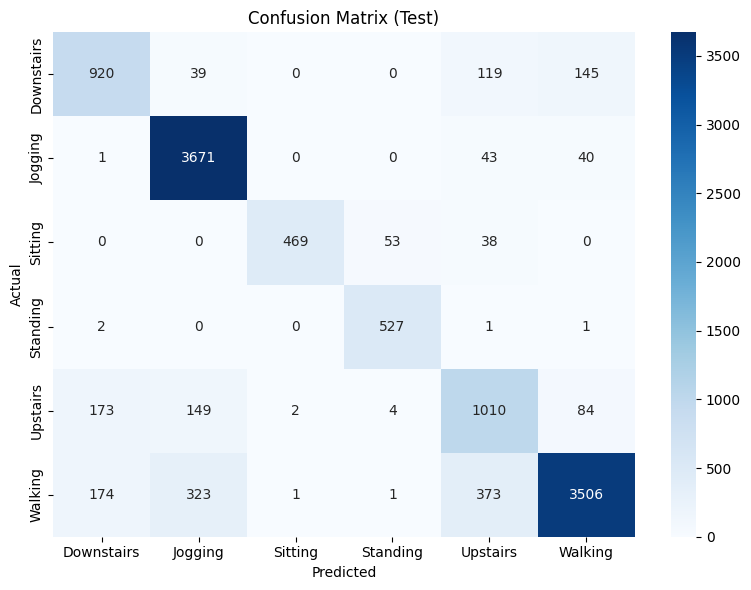

In [17]:
#12.Reports
y_pred_prob = model.predict(X_test, batch_size=64)
y_pred = y_pred_prob.argmax(axis=1)

print("\nClassification Report (Test):")
print(classification_report(y_test.flatten(), y_pred, target_names=le.classes_))

cm = confusion_matrix(y_test.flatten(), y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Test)")
plt.tight_layout()
plt.show()